In [11]:
import sys
!{sys.executable} -m pip install scipy

You should consider upgrading via the 'c:\Users\gaura\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import numpy as np
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

In [14]:
nbatch = 128
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(r'C:\Users\gaura\OneDrive\Documents\capstone1\Sourcecode\dataset\training',
                                                 target_size=(128,128),
                                                 batch_size =nbatch,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(r'C:\Users\gaura\OneDrive\Documents\capstone1\Sourcecode\dataset\test',
                                            target_size=(128,128),
                                            batch_size =nbatch,
                                            class_mode = 'binary')
training_dataset = tf.data.Dataset.from_generator(
    lambda: training_set,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 128, 128, 3], [None])
).repeat()

Found 1437 images belonging to 2 classes.
Found 604 images belonging to 2 classes.


Text(0.5, 0, 'Class')

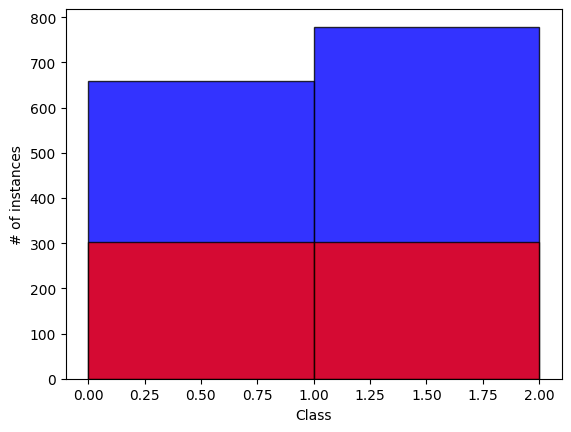

In [15]:
h1 = plt.hist(training_set.classes, bins=range(0,3), alpha=0.8, color='blue', edgecolor='black')
h2 = plt.hist(test_set.classes,  bins=range(0,3), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')

(128, 128, 128, 3) (128,)


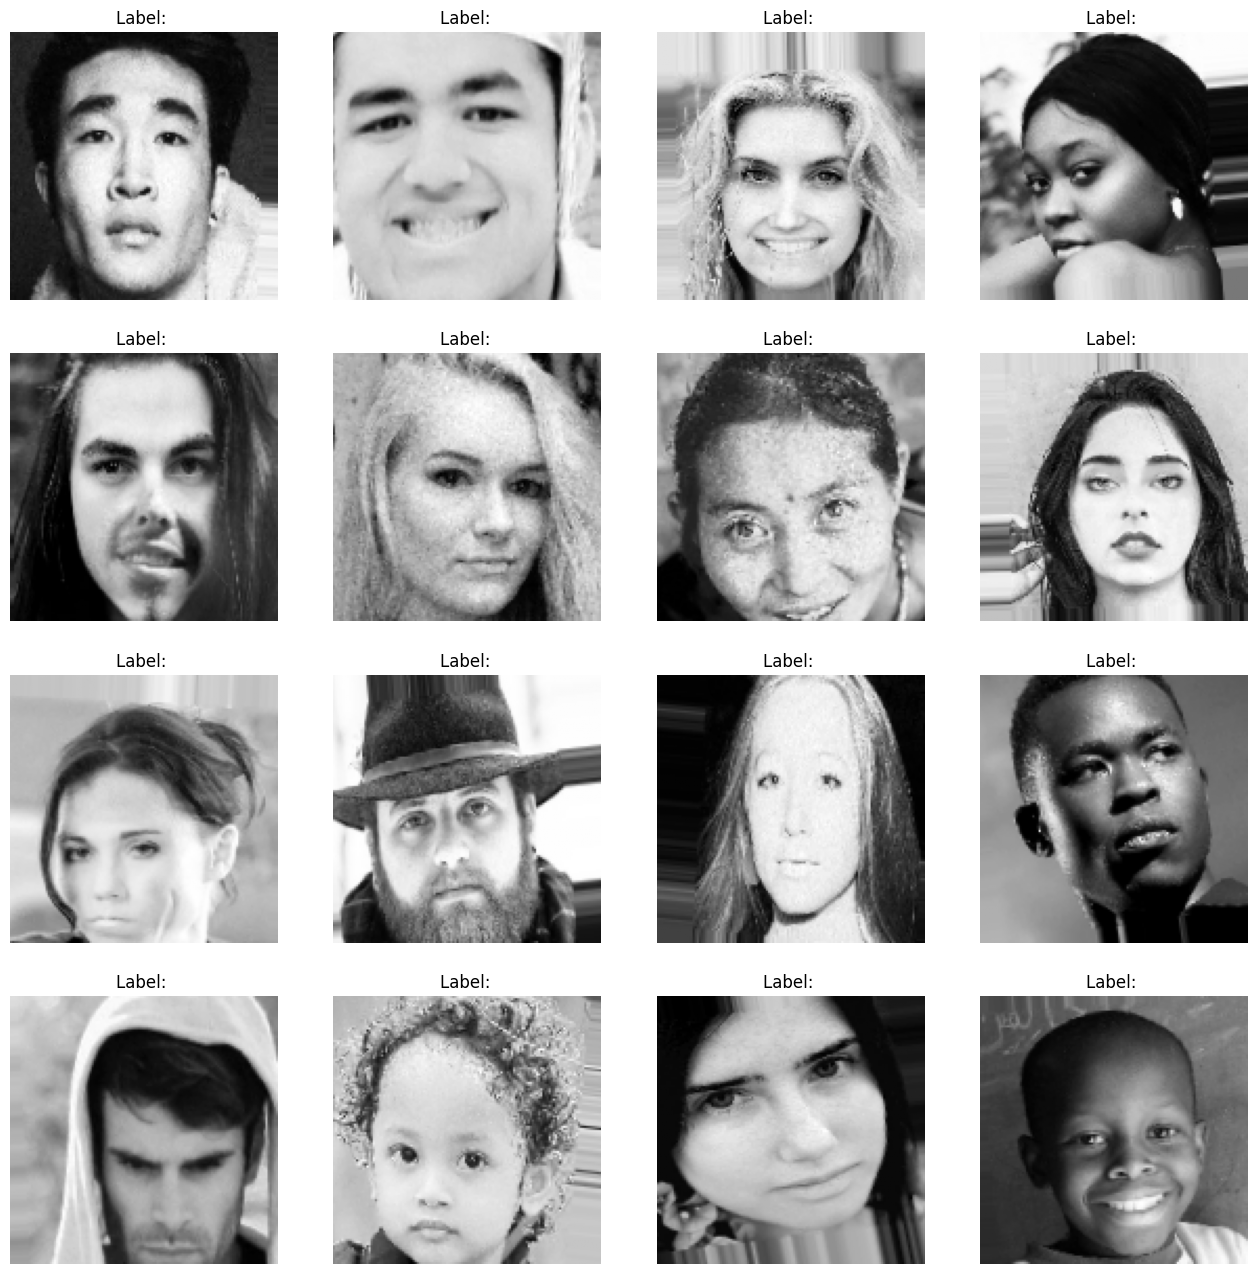

In [16]:
for X, y in training_set:
    print(X.shape, y.shape)
    plt.figure(figsize=(16,16))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title('Label: ')
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

# Convolutional Neural Net
The data looks resonable so now I will define a CNN model to train and use within our application.

In [17]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(128,128,3)))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(activation="relu",
                units=256))

model.add(Dense(activation="sigmoid",
                units=1))

model.summary()

c:\Users\gaura\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

##### Compile the model

In [18]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Training
Finally we will train our model using some keras helper functions. We are not doing any hyper-parameter optimization so we will not define a separate testing and validation set. We can however evaluate our model further in real time within the application.

In [22]:
# callbacks_list = [
#     EarlyStopping(monitor='val_loss', patience=10),
#     ModelCheckpoint(filepath='/content/drive/MyDrive/Capp/my_mode.keras', monitor='val_loss', save_best_only=True, mode ='max'),
# ]

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks_list = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='model_checkpoint.keras',  # saves in Sourcecode folder
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    ),
]

In [23]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [35]:
history = model.fit(
        training_dataset,
        steps_per_epoch=80,
        epochs=1,
        validation_data=test_set,
        validation_steps=28,
        callbacks = callbacks_list
    )

model.save("transfer_model.keras")

80/80 ━━━━━━━━━━━━━━━━━━━━ 282s 4s/step - accuracy: 0.5497 - loss: 0.6883 - val_accuracy: 0.6175 - val_loss: 0.6698


In [25]:
import pickle

with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [27]:
training_set.class_indices

{'fake': 0, 'real': 1}

Text(0.5, 0, '# of epochs')

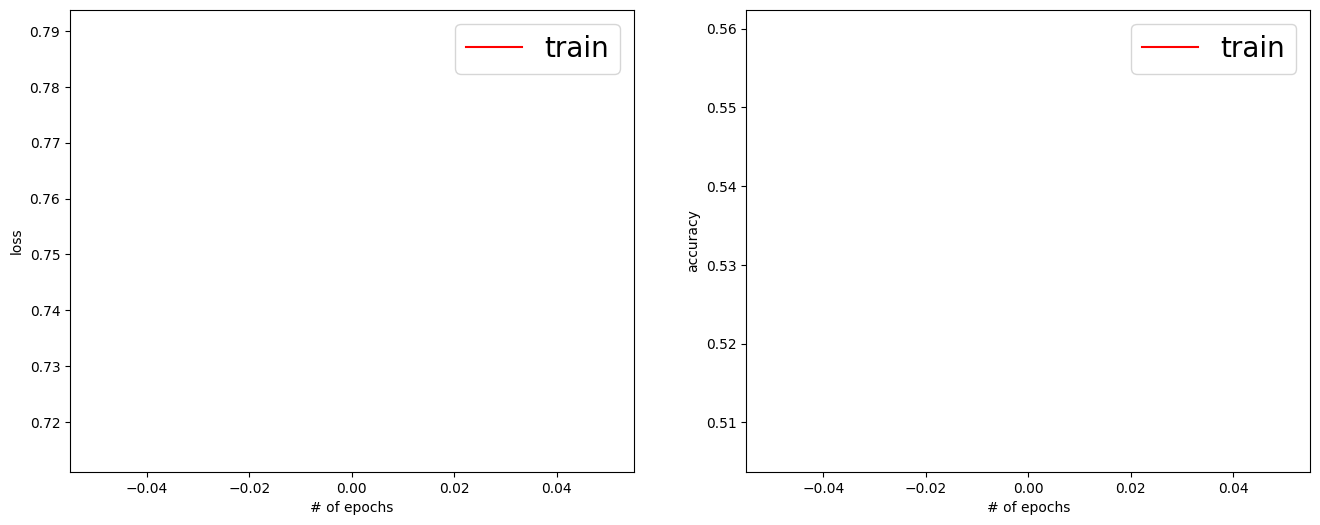

In [28]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'],     'r-', label='train')
#plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['accuracy'],     'r-', label='train')
#plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')

# Prediction
Now the model is trained so I used some real images and edited that image so that we can analysis model is working correcly or not.

In [29]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

In [30]:
def ImagePrediction(loc):
    test_image = load_img(loc, target_size = (128,128))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis =0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        predictions = 'Fake'
    else:
        predictions = 'Real'
    print('Prediction: ',predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Prediction:  Fake


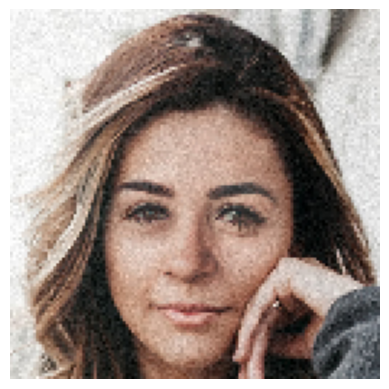

In [31]:
img = input("Enter Location of Image to predict: ")
test_image_1 = ImagePrediction(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction:  Fake


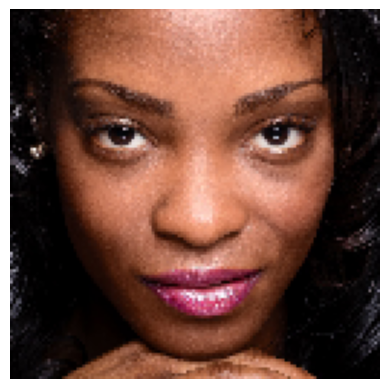

In [32]:
img = input("Enter Location of Image to predict: ")
test_image_2 = ImagePrediction(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction:  Fake


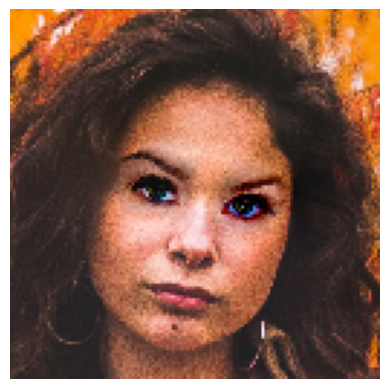

In [33]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction:  Fake


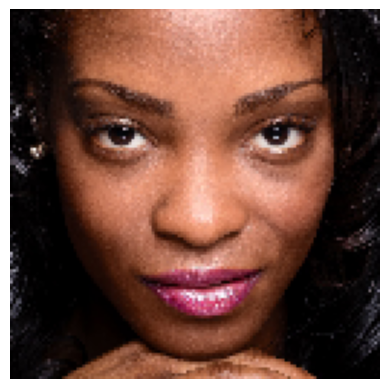

In [34]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

## Result
3 out of 4 images is predicted correctly althrough model is not trained well by incereasing epoc near about 40 will probably make this model perfectly trained but that will require 5-6hr for training.

---
### 🚀 Developed by Gaurav Kumar  
Machine Learning | Deep Learning | AI
---